In [1]:
import torch
from torch.utils.data import Dataset


# Define the custom dataset
class SimpleDataset(Dataset):
    def __init__(self):
        # Sample data: 4 data points with one feature each
        self.data = torch.tensor([[1, 1, 1], [2, 2, 2], [0, 1, 0]], dtype=torch.float16)
        # Corresponding labels for each data point
        self.labels = torch.tensor([0, 1, 0, 1])

    def __len__(self):
        # Number of data points
        return len(self.data)

    def __getitem__(self, idx):
        # Return the feature and label at the given index
        return self.data[idx], self.labels[idx]


dataset = SimpleDataset()

from utils.builders import GraphBuilder
from utils.metrics import Similarity

gb = GraphBuilder(Similarity())

KeyboardInterrupt: 

In [ ]:
from torch_geometric.data import Data

# g = Data(X, y)
g.x

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4]])

In [ ]:
g.x = X
g.x

array([[3, 3, 3],
       [2, 2, 2],
       [4, 4, 4],
       [1, 1, 1]])

In [2]:
from utils.metrics import Similarity, Uncertainty, UCAggregator
from utils.builders import GraphBuilder 
from utils.selection import Selector
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pipeline import GAL
from ref.ActiveLearning_OG import AL
from sklearn.linear_model import LogisticRegression

import pickle

with open('data/dataset_q1.pkl', 'rb') as f:
	dataset = pickle.load(f)

train_size, pool_size, test_size = None, 1_000, 1_000

iterations = 50
budg_per = 20

dataset['available_pool_samples'] = dataset['available_pool_samples'][:pool_size]
dataset['available_pool_labels'] = dataset['available_pool_labels'][:pool_size]

dataset["test_samples"] = dataset["test_samples"][:test_size]
dataset["test_labels"] = dataset["test_labels"][:test_size]


In [9]:
# import matplotlib.pyplot as plt

# plt.hist(dataset['available_pool_labels'])
# plt.show()

# plt.hist(dataset['train_labels'])
# plt.show()

In [ ]:
from pipeline import GAL
import pipeline as p
import importlib
importlib.reload(p)


al = GAL(dataset=dataset, 
		 classifier=LogisticRegression(), 
		 budget_per_iter=budg_per, 
		 iterations=iterations,
		 gnn_epochs=15,
		 AL4GE=True,
		 use_gnn=True)

res_gal = al.run(plot=False)

AL_class = AL(dataset=dataset,
			  selection_criterion='custom',
			  iterations=iterations,
			  budget_per_iter=budg_per,
			  train_limit=10000,)

res_al = AL_class.run_pipeline()

plt.plot(res_gal, label='res_gal')
plt.plot(res_al, label='res_al')
plt.legend()
plt.show()

In [ ]:
a = np.concat([dataset["train_labels"], dataset["available_pool_labels"], dataset["test_labels"]])
np.unique(a)

array([0, 1, 2, 3])

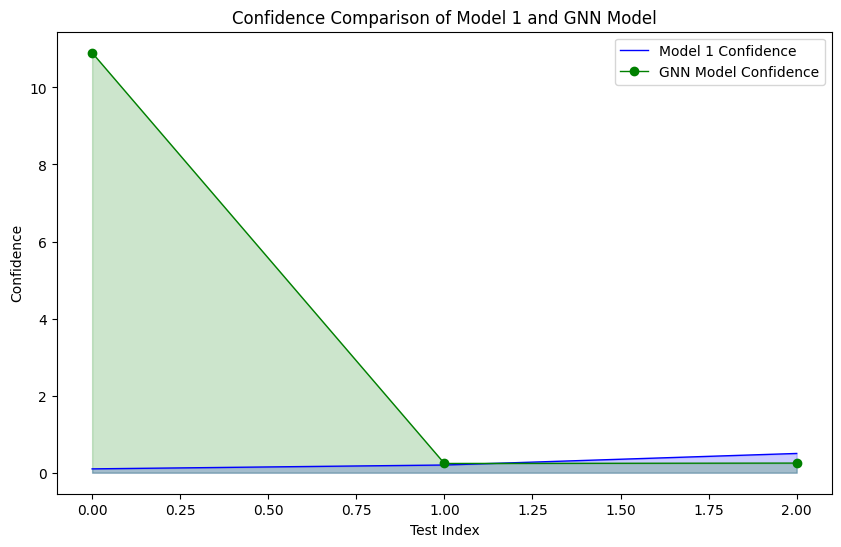

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

out = np.array([0.1, 0.2, 0.5])
gnn_out = np.array([10.9, 0.24, 0.25])


test_idx = np.arange(len(out))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(test_idx, out, label='Model 1 Confidence', color='blue', linestyle='-', linewidth=1)
plt.plot(test_idx, gnn_out, label='GNN Model Confidence', color='green', marker='o', linestyle='-', linewidth=1)

# Highlight the area under each curve
plt.fill_between(test_idx, out, color='blue', alpha=0.2)
plt.fill_between(test_idx, gnn_out, color='green', alpha=0.2)

# Labels and title
plt.xlabel('Test Index')
plt.ylabel('Confidence')
plt.title('Confidence Comparison of Model 1 and GNN Model')
plt.legend()

# Display the plot
plt.show()

In [ ]:
from utils.metrics import Similarity
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import torch

class GraphBuilder:
    def __init__(self, metric: Similarity):
        self.metric = metric

    def connect(self, A: np.ndarray, threshold: float = 1):
        """Function to get the edges of `N` nodes, based on affinity matrix.

        Args:
            A (ndarray): Affinity matrix of size `NxN`, where `N` is the number of nodes.
            threshold (float, optional): nodes with affinity less than the threshold will be connected. Defaults to 1.

        Returns:
            ndarray: indices of connected nodes `2xN`
        """
        return np.vstack(np.where(A < threshold))

    def build(self, X: np.ndarray, y: np.ndarray = None, threshold: float = None, pytorch=False):
        """build graph from tabular data.

        Args:
            X (ndarray): data matrix.
            y (ndarray, optional): labels of the data.
            threshold (float, optional): Threshold for affinity. Defaults to .1 of max distance.

        Returns:
            (Graph, ndarray): graph `G` which is an object of networkx.Graph and its edges `E` in GNN format (2xN).
        """
        A = self.metric(X)
        if threshold is None:
            threshold = .1 * A.max()
        
        E = self.connect(A, threshold)
  
        if pytorch:
            return Data(x=torch.tensor(X), y=torch.tensor(y), edge_index=torch.tensor(E))
        
        G = nx.Graph()
        G.add_nodes_from([(idx, dict(embedding=tuple(x), label=(y[idx] if y is not None else None))) for idx, x in enumerate(X)])
        G.add_edges_from(zip(*E))
        
        return G

    def __call__(self, X, y, threshold: float = None, pytorch: bool = False):
        return self.build(X, y, threshold, pytorch=pytorch)

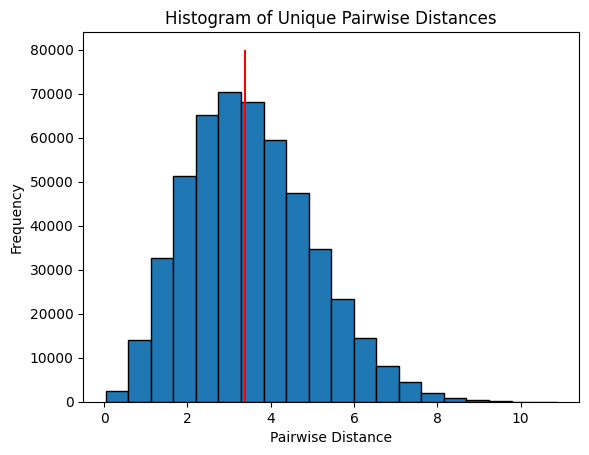

In [ ]:
from torch_geometric.data import Data
# from utils.builders import GraphBuilder
from utils.metrics import Similarity

cos_sim = Similarity("euclidean")

distance_matrix = cos_sim(dataset["available_pool_samples"])

np.fill_diagonal(distance_matrix, np.nan)

# Extract the upper triangular part without the diagonal (where k=1 starts at the first off-diagonal)
unique_distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

# Plot the histogram
plt.hist(unique_distances, bins=20, edgecolor='black')
plt.vlines(x=np.quantile(unique_distances, q=0.5), ymin=0, ymax=80_000, colors="red")
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Unique Pairwise Distances")
plt.show()

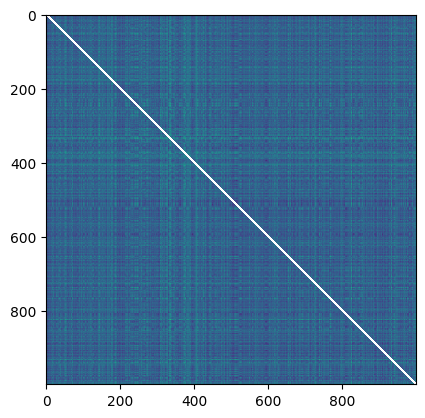

In [ ]:
plt.imshow(distance_matrix)

In [ ]:
np.quantile(unique_distances, q=0.5)

np.float64(3.39187473378321)

In [ ]:
d.x

tensor([[ 1.6147,  0.2876, -0.6458],
        [ 1.6655,  1.6184,  1.3290],
        [ 2.7325,  1.9390,  1.4140],
        [-2.2381, -0.4079, -1.2023],
        [ 1.0358,  0.9058,  0.5039],
        [-2.2010,  1.4688,  0.1608],
        [-2.5032,  0.6540, -2.9630],
        [-0.6284,  1.9446,  0.7884],
        [-1.5490,  0.0123, -0.6604],
        [ 1.0501, -0.0342,  1.7191],
        [ 0.8971,  0.1662,  1.5717],
        [-0.8893, -0.4173, -2.3037],
        [-0.2611,  1.2894,  0.5235],
        [ 0.2473,  0.7888,  1.2075],
        [-2.4616, -1.8651,  0.0053]], dtype=torch.float64)

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

In [ ]:
X = iris["data"]
y = iris["target"]


idx = np.random.permutation(np.arange(len(X)))
X = X[idx]
y = y[idx]

train_size, pool_size, test_size = np.array(len(X) * np.array([0.1, 0.7, 0.2]), dtype=int)

# Ensure sizes add up to the total length to avoid indexing errors
adjustment = len(X) - (train_size + pool_size + test_size)
test_size += adjustment  # Add any discrepancy to the test set

# Split data based on the calculated sizes
final = {
    "train_samples": X[:train_size],
    "train_labels": y[:train_size],
    "available_pool_samples": X[train_size:train_size + pool_size],
    "available_pool_labels": y[train_size:train_size + pool_size],
    "test_samples": X[train_size + pool_size:],
    "test_labels": y[train_size + pool_size:],
}

In [ ]:
import pickle

with open('./data/iris.pkl', 'wb') as f:
    pickle.dump(final, f)

In [ ]:
print(train_size, pool_size, test_size)
final["test_labels"].shape

15 105 30


(30,)

In [ ]:
print(X[train_size: train_size + pool_size].shape)

(105, 4)
